#Homework 3: Decision trees

In [92]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

####1. Use the file bank.csv to explore the dataset. Observe the features: Are they numbers? Are they strings? Are they binary? Are they continuous?

In [93]:
bank_csv = pd.read_csv('/Users/Bronco/Classes/General_assembly/DAT_SF_13/homework/HW3/bank.csv', sep = ';')
bank_csv.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [94]:
bank_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 635.8+ KB


The data consists of a mix of categorical and continuous variables. Some of the variables clearly fall into one or another category, however this is not always the case. For instance, education consists of the classes "primary," "secondary," and "tertiary." These are provided as strings, however they clearly are ordered in some sense. A number of the variables are binary, but provided as "yes/no" strings. These can be converted to binary integers by mapping to 1 and -1 or 0. For categorical variables such as marital status or job, these are more difficult to deal with as they are not immediately convertible to unordered binary types. This can be accomplished, however, with the use of dummy variables and "one-hot" encoding. One variable that is particularly challenging in this dataset is the inclusion of months and days. Without a year it is not the most useful data as it cannot be clearly converted to a continuous integer, such as epoch time, since most comparison operators (<,>) are invalid on cyclical variables. In addition, the inclusion of the year would permit the inference of day of the week, which might be very significant. Whether or not it is a holiday might also be a good feature to include. Finally, as stated on the UCI page where the dataset is from, "duration" is a poor variable to include in the decision tree as it is highly dependent on the outcome (i.e. whether or not they purchased a loan). Since this algorithm aims to predict whether someone will purchase a loan before contacting them it does not make sense to include duration of the phone call in the decision about whether to contact them in the first place.

####2. Learn about label encoders at the following link (?) and use what you learn to transform the features to numerical features.

Label encoding is one of several techniques to handle unordered categorical data. Label encoding transforms labels (e.g. "job" in the current data set) into indices that refer back to the categories. The reason for this is that many machine learning algorithms do not work well with non-numerical data types. However, turning unordered categorical variables into ordered numerical variables implies a relationship among the categories that may be false. For instance, "services," "management," and "blue collar" may be transformed into 0, 1, and 2, respectively; however there is no reason to suppose "blue collar" > "services." Therefore, another way to encode categorical variables is to turn the categories into a series of binary types, such that a column variable encoding $n$ categories would be transformed into $n-1$ new binary columns in a process called "one-hot" or "one-of-K" encoding. This is particularly useful for decission trees as it permits binary splits on multi-valued categorical data where each category is treated as an independent variable (i.e. `"job":"blue collar"` becomes `is_blue_collar: [0|1]`). In pandas, the `get_dummies` function implements "one-hot" encoding on categorical variables, generating $n$ new columns, one of which is redundent since a zero in $n-1$ columns always implies a 1 in the $n$th column.

In [95]:
bank_csv2 = pd.get_dummies(bank_csv, columns = ['job', 'marital', 'contact', 'poutcome'])

In [96]:
bank_csv2.y = bank_csv2.y.map({'no':0,'yes':1})
bank_csv2.education = bank_csv2.education.map({'unknown':0,'primary':1,'secondary':2,'tertiary':3})
bank_csv2.housing = bank_csv2.housing.map({'no':0,'yes':1})
bank_csv2.loan = bank_csv2.loan.map({'no':0,'yes':1})
bank_csv2.default = bank_csv2.default.map({'no':0,'yes':1})
bank_csv2.month = bank_csv.month.map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12})

In [97]:
for c in bank_csv2.columns:
    if 'unknown' in c:
        bank_csv2.drop(c, axis = 1, inplace = True)

In [98]:
# This is not actually useful since the sklearn decision tree algorithm cannot deal with ambiguously ordered dates
dt = pd.to_datetime(bank_csv2.day.astype(str) + '-' + bank_csv2.month.astype(str), format = '%d-%m')
bank_csv2['datetime'] = dt
bank_csv2.drop(['day','month'], axis = 1, inplace = True)

####3. Build a decision tree model to predict whether a prospect will buy the product.

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split, cross_val_score

In [100]:
dtc = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)
X_train, X_test, y_train, y_test = train_test_split(bank_csv2.drop(['datetime','y','duration'], axis = 1, inplace = False), bank_csv2.y, test_size = 0.33, random_state = 1)

In [101]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=1, splitter='best')

In [102]:
dtc.score(X_test, y_test)

0.87734584450402142

####4. Evaluate the accuracy of your decision tree model using cross validation.

In [103]:
cvs = cross_val_score(dtc, 
                      bank_csv2.drop(['datetime','y','duration'], axis = 1, inplace = False), 
                      bank_csv2.y, 
                      cv = 20, 
                      n_jobs = -1
                     )

In [104]:
np.mean(cvs)

0.88033994776032143

In [127]:
depths = range(1,31)
scores = []
errs = []
for max_depth in depths:
    dtc = DecisionTreeClassifier(max_depth = max_depth, criterion = 'gini', random_state = 1)
    cvs = cross_val_score(dtc, 
                          bank_csv2.drop(['datetime','y','duration'], axis = 1, inplace = False), 
                          bank_csv2.y, 
                          cv = 10, 
                          n_jobs = -1
                         )
    scores.append(np.mean(cvs))
    errs.append(np.std(cvs, ddof = -1))

1


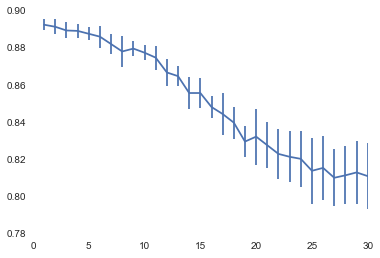

In [128]:
%matplotlib inline
sns.plt.errorbar(depths, scores, yerr = errs)
print depths[np.argmax(np.array(scores))]

In [136]:
dtc = DecisionTreeClassifier(max_depth = 1, random_state = 1)
cvs = cross_val_score(dtc, 
                      bank_csv2.drop(['datetime','y','duration'], axis = 1, inplace = False), 
                      bank_csv2.y, 
                      cv = 10, 
                      n_jobs = -1
                     )
print np.mean(cvs)

0.892944773291


In [132]:
feature_cols = bank_csv2.drop(['datetime','y','duration'], axis = 1, inplace = False).columns

In [118]:
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
import pydot
dot_data = StringIO() 
export_graphviz(dtc, out_file=dot_data, feature_names = feature_cols) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("Bank_tree_no_dur.png")

True

<img src="Bank_tree_no_dur.png">

In [137]:
dtc.fit(X_train, y_train)
pd.DataFrame({'Features':feature_cols,
              'Importances':dtc.feature_importances_}).sort('Importances', 
                                                             ascending = False, 
                                                             axis = 0).head()

,Features,Importances
27,poutcome_success,1
1,education,0
26,poutcome_other,0
25,poutcome_failure,0
24,contact_telephone,0


Since the variable "poutcome_success" seems to explain the majority of future success it would be good to see how dropping "poutcome" affects the tree:

In [270]:
depths = range(1,31)
scores = []
errs = []
for max_depth in depths:
    dtc = DecisionTreeClassifier(max_depth = max_depth, criterion = 'gini', random_state = 1)
    cvs = cross_val_score(dtc, 
                          bank_csv2.drop(['datetime',
                                          'y',
                                          'duration',
                                          'poutcome_success',
                                          'poutcome_other', 
                                          'poutcome_failure'], 
                                           axis = 1, inplace = False), 
                          bank_csv2.y, 
                          cv = 10, 
                          n_jobs = -1)
    scores.append(np.mean(cvs))
    errs.append(np.std(cvs, ddof = -1))

4


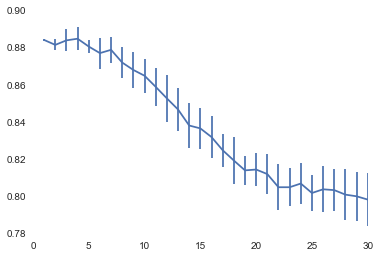

In [265]:
sns.plt.errorbar(depths, scores, yerr = errs)
print depths[np.argmax(np.array(scores))]

In [266]:
features = bank_csv2.drop(['datetime',
                           'y',
                           'duration',
                           'poutcome_success',
                           'poutcome_other', 
                           'poutcome_failure'], 
                            axis = 1, inplace = False)

feature_cols = features.columns

In [312]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(bank_csv2.y, n_folds = 10, random_state = 1)
dtc = DecisionTreeClassifier(max_depth = 4, random_state = 1)
df = pd.DataFrame(index = feature_cols)
for train, test in skf:
    dtc.fit(features.iloc[train],bank_csv2.y[train])
    importances = dtc.feature_importances_
    temp_s = pd.Series(importances, index = feature_cols)
    df = pd.concat([df,temp_s], axis = 1 )
stds = df.std(axis = 1)
means = df.mean(axis = 1)
df2 = pd.concat([means,stds], axis = 1).sort(ascending = False, columns = 0)
df2.columns = ['mean importances', 'std importances']
df2.head(12)

,mean importances,std importances
pdays,0.580828,0.023029
age,0.159846,0.021623
housing,0.073151,0.008014
contact_cellular,0.059644,0.008028
balance,0.050637,0.020410
marital_married,0.023018,0.013038
marital_divorced,0.022556,0.012839
job_retired,0.021656,0.005209
job_admin.,0.003776,0.008014
job_student,0.002790,0.008823


In [313]:
dtc = DecisionTreeClassifier(max_depth=4, criterion='gini', random_state=1)
cvs = cross_val_score(dtc2,
                features, 
                bank_csv2.y, 
                cv = 10)

cvs.mean()

0.8854226493973314

Dropping "poutcome" reveals that "pdays" and "age" become more significant predictors, although the total model generalization score decreases somewhat.

In [315]:
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
import pydot
dtc.fit(features, bank_csv2.y)
dot_data = StringIO() 
export_graphviz(dtc, out_file=dot_data, feature_names = feature_cols) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("Bank_tree_no_dur_pout.png")

True

<img src="Bank_tree_no_dur_pout.png" height = "180%" width = "180%">

####5. Repeat the analysis and cross validation with the file bank-additional-full.csv. How does the performance of the model change (with the additional training examples and additional features)?

In [316]:
full_bank_csv = pd.read_csv('/Users/Bronco/Classes/General_assembly/DAT_SF_13/homework/HW3/bank-additional-full.csv', sep = ';')
full_bank_csv.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [317]:
for c in sorted(full_bank_csv.columns):
    print c,': ',full_bank_csv[c].nunique(),', ',full_bank_csv[c].dtype

age :  78 ,  int64
campaign :  42 ,  int64
cons.conf.idx :  26 ,  float64
cons.price.idx :  26 ,  float64
contact :  2 ,  object
day_of_week :  5 ,  object
default :  3 ,  object
duration :  1544 ,  int64
education :  8 ,  object
emp.var.rate :  10 ,  float64
euribor3m :  316 ,  float64
housing :  3 ,  object
job :  12 ,  object
loan :  3 ,  object
marital :  4 ,  object
month :  10 ,  object
nr.employed :  11 ,  float64
pdays :  27 ,  int64
poutcome :  3 ,  object
previous :  8 ,  int64
y :  2 ,  object


In [318]:
full_bank_csv = pd.read_csv('/Users/Bronco/Classes/General_assembly/DAT_SF_13/homework/HW3/bank-additional-full.csv', sep = ';')
full_bank_csv['y'] = full_bank_csv.y.map({'no':0,'yes':1})
full_bank_csv['education'] = full_bank_csv.education.map({'basic.4y':1, 
                                                          'high.school':4, 
                                                          'basic.6y':2, 
                                                          'basic.9y':3, 
                                                          'professional.course':5,
                                                          'unknown':4, 
                                                          'university.degree':6, 
                                                          'illiterate':0})
full_bank_csv['contact'] = full_bank_csv.contact.map({'telephone':0,'cellular':1})
full_bank_csv.drop('duration', axis = 1, inplace = True)
columns = ['day_of_week','default','housing','job','loan','marital','month','poutcome']
for c in columns:
    dummies = pd.get_dummies(full_bank_csv[c], prefix = c)
    if any(map(lambda x: 'unknown' in x, dummies)):
        for d in dummies.columns:
            if 'unknown' in d:
                dummies.drop(d, axis = 'columns', inplace = True)
                break
    else:
        dummies = dummies.iloc[:,:-1]
    full_bank_csv.drop(c, axis = 1, inplace = True)
    full_bank_csv = pd.concat((full_bank_csv, dummies.iloc[:,:]), axis = 1)

In [319]:
full_bank_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 47 columns):
age                     41188 non-null int64
education               41188 non-null int64
contact                 41188 non-null int64
campaign                41188 non-null int64
pdays                   41188 non-null int64
previous                41188 non-null int64
emp.var.rate            41188 non-null float64
cons.price.idx          41188 non-null float64
cons.conf.idx           41188 non-null float64
euribor3m               41188 non-null float64
nr.employed             41188 non-null float64
y                       41188 non-null int64
day_of_week_fri         41188 non-null float64
day_of_week_mon         41188 non-null float64
day_of_week_thu         41188 non-null float64
day_of_week_tue         41188 non-null float64
default_no              41188 non-null float64
default_yes             41188 non-null float64
housing_no              41188 non-null float64
housing_yes 

In [320]:
full_data = full_bank_csv.drop('y', axis = 1)
full_target = full_bank_csv.y

In [321]:
depths = range(1,25)
scores = []
stds = []
for max_depth in depths:
    dtree = DecisionTreeClassifier(max_depth = max_depth, random_state = 1)
    cvs = cross_val_score(dtree,full_data,full_target, cv = 8, n_jobs = -1)
    scores.append(np.mean(cvs))
    stds.append(np.std(cvs, ddof = -1))

2


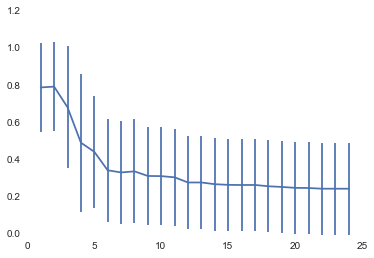

In [322]:
sns.plt.errorbar(depths, scores, yerr = stds)
print depths[np.argmax(np.array(scores))]

In [325]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(full_target, n_folds = 8)
dtree = DecisionTreeClassifier(max_depth = 2)
df = pd.DataFrame(index = full_data.columns)
for train, test in skf:
    dtree.fit(full_data.iloc[train],full_target[train])
    importances = dtree.feature_importances_
    temp_s = pd.Series(importances, index = full_data.columns)
    df = pd.concat([df,temp_s], axis = 1 )
stds = df.std(axis = 1)
means = df.mean(axis = 1)
df2 = pd.concat([means,stds], axis = 1).sort(ascending = False, columns = 0)
df2.columns = ['mean importances', 'std importances']
df2.head(10)

,mean importances,std importances
nr.employed,0.576299,0.359841
euribor3m,0.218622,0.407502
pdays,0.119816,0.052489
cons.conf.idx,0.031745,0.036651
emp.var.rate,0.031276,0.088463
month_aug,0.014247,0.040297
month_oct,0.007994,0.014941
age,0.000000,0.000000
month_apr,0.000000,0.000000
job_technician,0.000000,0.000000


In [328]:
X_train, X_test, y_train, y_test = train_test_split(full_data, full_target, test_size = .33)
dtree = DecisionTreeClassifier(max_depth=2, random_state=1)
dtree.fit(X_train, y_train)
np.mean(dtree.predict(X_test) == y_test)

0.90156698300595894

In [331]:
dot_data = StringIO() 
export_graphviz(dtree, out_file=dot_data, feature_names = full_data.columns) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("Full_data_bank_tree.png")

True

<img src="Full_data_bank_tree.png">

Looks like the euribor rate is a very good predictor of who will take out a loan. However, looking at the gini importances and the standard deviations associated with them, it seems that the particular splits used to train the model have a large impact on the results. The number of employees indicator is also a good predictor, but it's unclear what this really has to do with someone's choice to take out a loan. The consumer confidence index makes sense as a predictor, but it is never a very good one.